**Performing PCA with an Undercomplete Linear Autoencoder:**
- Meaning of undercomplete: Internal representation of the autoencoder has a lower dimensionality than the input data. The autoencoder cannot trivially copy its inputs to the codings (outputs) - yet it must find a way to output a copy of its inputs. It is forced to learn the most important features in the input data (and drop the unimportant ones). 

If the autoencoder uses only linear activations and the cost function is the mean squared error (MSE), then it ends up performing principal component analysis.

The following code builds a simple linear autoencoder to perform PCA on a 3D dataset, projecting it to 2D

In [1]:
import tensorflow as tf

In [3]:
import numpy as np
from scipy.spatial.transform import Rotation

In [10]:
import matplotlib.pyplot as plt

In [17]:
from sklearn.manifold import TSNE

In [2]:
encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])

autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)

autoencoder.compile(loss='mse', optimizer=optimizer)

In [4]:
m = 60
X = np.zeros((m, 3)) # initialize 3D dataset
np.random.seed(42)

angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

In [6]:
X_train.shape

(60, 3)

In [7]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)

In [8]:
codings = encoder.predict(X_train)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


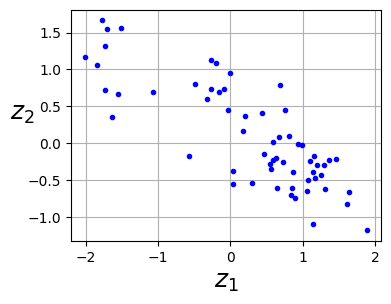

In [12]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

Note: This autoencoder found the best 2D plane to project the data onto, preserving as much variance in the data as it could - just like PCA.

**Stacked Autoencoders:**
- Just like other neural nets - autoencoders can have multiple hidden layers. In this case they are called stacked autoencoders (or deep autoencoders). Adding more layers helps the autoencoder learn more complex codings. That said - be careful not to make the autoencoder too powerful. Imagine an encoder so powerful that it learns to map each input to a single arbitrary number and the decoder learns the reverse mapping. needs to learn useful representations not just map the outputs to inputs. 

- The architecture of a stacked autoencoder is typically symmetrical with regard to the central hidden layer (the coding layer). 

**Implementing a Stacked Autoencoder Using Keras:**
- You can implement a stacked autoencoder very much like a regular deep MLP

In [13]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [14]:
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])

stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28*28),
    tf.keras.layers.Reshape([28,28])
])

stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")

history = stacked_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0335 - val_loss: 0.0182
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0172 - val_loss: 0.0162
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0159 - val_loss: 0.0156
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0146 - val_loss: 0.0147
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0144 - val_loss: 0.0145
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0143 - val_loss: 0.0144
Epoch 9/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0141 - val_loss: 0.0142
Epoch 10/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0140 - val_loss: 0.0141
Epoch 11/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 12/20
1719/1719 ━━━━━━━

**Visualizing the Reconstructions:**
- One way to ensure an autoencoder is properly trained is to compare the inputs and outputs: the differences should not be too significant. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


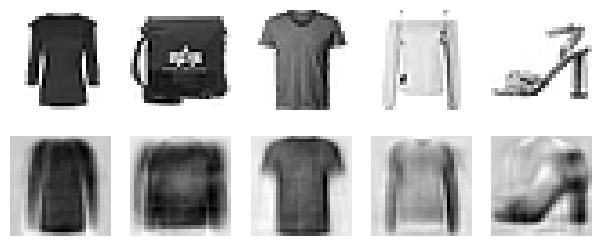

In [16]:
def plot_reconstructions(model, images=X_valid, n_images = 5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images*1.5,3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")


plot_reconstructions(stacked_ae)
# save_fig("reconstruction_plot")  # extra code – saves the high res figure
plt.show()

The reconstructions are recognizable - but a bit too lossy. We need to train the model for longer, or make the encoder and decoder deeper, or make the codings larger.But - making the network too powerful - will make it not learn any useful patterns so for now just stick with it.

**Visualizing the Fashion MNIST:**
- Now that we've trained a stacked autoencoder, we can use it to reduce the dataset's dimensionality. For visualization, this doesn't give great results compared to other dimensionality reduction algorithms, but one big advantage of autoencoders is that they can handle large datasets with many instances and many features. So, one strategy is to use an autoencoder to reduce dimensionality then use another dimensionality reduction algorithm for visualization. 
- We use this strategy to visualize the fashion MNIST dataset. First, we'll use the encoder from before to reduce the dimensionality down to 30, then we'll use scikit-learn's implementation of t-SNE to reduce the dimensionality down to 2 for visualization. 

In [18]:
X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


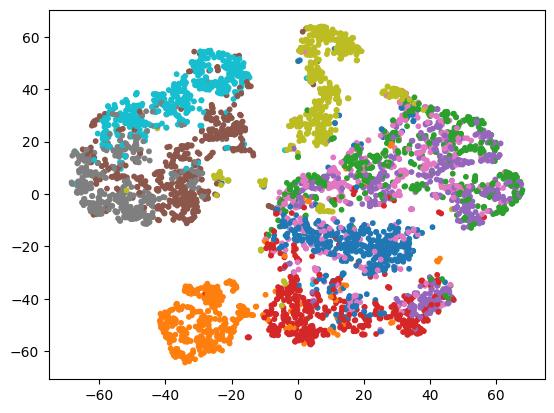

In [19]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

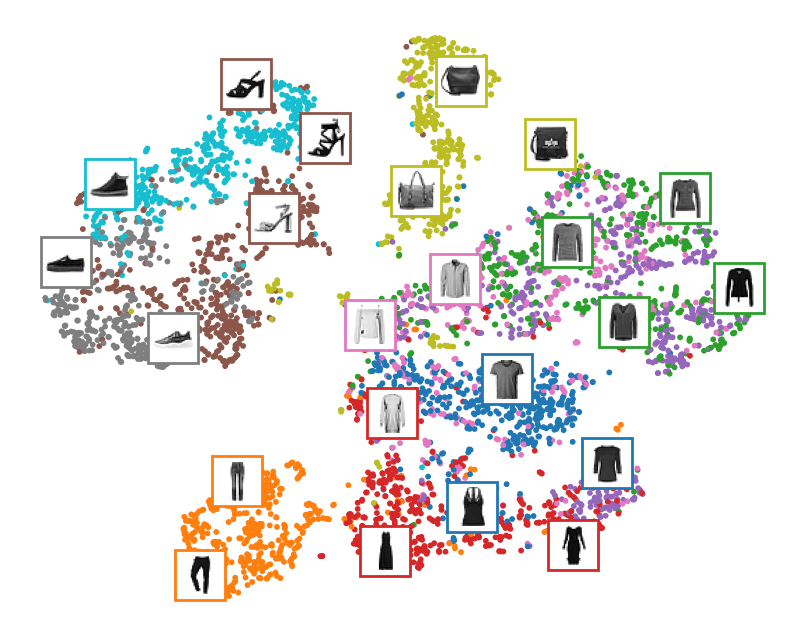

In [21]:
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

So - autoencoders can be used for dimensionality reduction. Another approach is for unsupervised pretraining:

**Unsupervised Pretraining using Stacked Autoencoders:**

Complex supervised task - w/o a lot of training data - one solution is to find a neural net that performs a similar task and to reuse its lower layers. 
- Similarly if you have a large dataset but most of it is ublabeled, you can first train a stacked autoencoder using all the data, then reuse the lower layers to create a neural net for your actual task and train it with the labeled data. When training - if you really don't have much labeled training data - you may want to freeze the pretrained layers - at least the lower ones.

Next, we look at a few techniques for training stacked autoencoders:

**Tying Weights:**

When an autoencoder is neatly symmetrical - a common technique is to tie the weights of the decoder layers to the weights of the encoder layers. This halves the number of weights in the model, speeding up training and limiting the risk of overfitting. Specifically, if the autoencoder has a total of N layers 

To tie the weights between layers using keras, lets define a custom layer:

In [35]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input.shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

Custom layer acts like a regular dense layer, but uses another dense layer's weights. However it uses its own bias vector Now, we can build a stacked autoencoder but with the decoder's dense layers tied to the encoder's dense layers:

In [36]:
dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28,28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

In [37]:
# extra code – compiles and fits the model
tied_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = tied_ae.fit(X_train, X_train, epochs=10,validation_data=(X_valid, X_valid))

Epoch 1/10

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0345 - val_loss: 0.0174
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0169 - val_loss: 0.0159
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0157 - val_loss: 0.0153
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0151 - val_loss: 0.0149
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0147 - val_loss: 0.0145
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0143 - val_loss: 0.0143
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0143 - val_loss: 0.0142
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0140 - val_loss: 0.0141
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0139 - val_loss: 0.0139
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0138 - val_loss: 0.0138


Model achieves - roughly the same reconstruction error as the previous model - using almost half of the number of parameters

**Training one autoencoder at a time:**

Rather than training 

**Convolutional Autoencoders:**
- Here's a basic convolutional autoencoder for fashion mnist:

In [53]:
conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28,28,1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2), # output: 14x14x16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),# output: 7x7x32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2), # output: 3x3x64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D() # output: (batch, 30)
])

conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3*3*16),
    tf.keras.layers.Reshape((3,3,16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, activation="relu", padding="same"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28,28])
])

conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

# compile and fit the model
conv_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = conv_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0450 - val_loss: 0.0202
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0194 - val_loss: 0.0178
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0170 - val_loss: 0.0160
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 0.0156 - val_loss: 0.0148
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 0.0146 - val_loss: 0.0144
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - loss: 0.0140 - val_loss: 0.0136
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 0.0135 - val_loss: 0.0132
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 0.0131 - val_loss: 0.0130
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 0.0128 - val_loss: 0.0126
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - loss: 0.0125 - val_loss: 0.0124


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


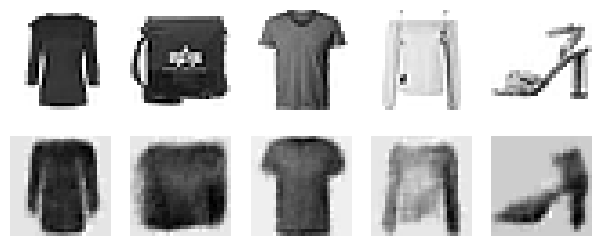

In [54]:
plot_reconstructions(conv_ae)
plt.show()

Formula for the output of a Conv2DTranspose layer:
- padding not same: output = strides*(input_height/width - 1) + filter_shape - (2*padding)
- if paddding is same: output = input_height * strides

checkout: [Stack_Overflow](https://stackoverflow.com/questions/50683039/conv2d-transpose-output-shape-using-formula)

Its also possible to have LSTM/RNN autoencoders, checkout this [repo](https://github.com/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb)

Up to now, in order to force the autoencoder to learn interesting features, we have limited the size of the coding layer - making it undercomplete. There are actually many other kinds of constraints that can be used, including ones that allow the coding layer to just be as large as the inputs, or even larger, resulting in an overcomplete autoencoder. 

**Denoising Autoencoders:**
- Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise free inputs. 
- The noise can be pure Gaussian noise added to the inputs, or it can be randomly switched-off inputs, just like dropout.
- The implementation is straightforward: regular stacked autoencoder with an additional dropout layer applied to the encoder's inputs (or, you could use a GaussianNoise layer instead). Recall that the dropout layer is only active during training - and so is the gaussian noise layer

In [55]:
dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])

dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28*28),
    tf.keras.layers.Reshape([28,28])
])

dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

In [56]:
# extra code – compiles and fits the model
dropout_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0400 - val_loss: 0.0214
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0225 - val_loss: 0.0199
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0212 - val_loss: 0.0190
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0204 - val_loss: 0.0186
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0200 - val_loss: 0.0181
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0196 - val_loss: 0.0179
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0194 - val_loss: 0.0176
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0191 - val_loss: 0.0176
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0190 - val_loss: 0.0173
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0189 - val_loss: 0.0172


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


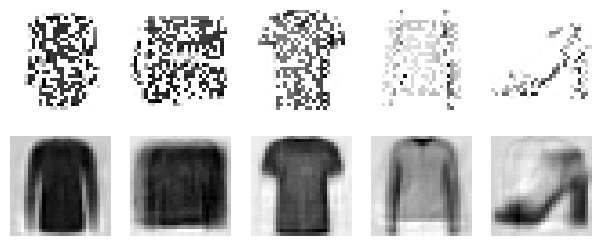

In [58]:
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True))
plt.show()